# ML accelerated CFD data analysis

This notebook reproduces key figures in our [PNAS paper](https://www.pnas.org/content/118/21/e2101784118) based on saved datasets. The data is stored in netCDF files in Google Cloud Storage, and the analysis uses xarray and JAX-CFD.

> Indented block



In [ ]:
! pip install -U xarray jax-cfd[data]==0.1.0

     |████████████████████████████████| 827 kB 7.7 MB/s 
     |████████████████████████████████| 134 kB 44.5 MB/s 
  Attempting uninstall: xarray
    Found existing installation: xarray 0.18.2
    Uninstalling xarray-0.18.2:
      Successfully uninstalled xarray-0.18.2


## Figure 1

Replication of the Figure 1 from the PNAS paper, except with a [bootstrap](https://en.wikipedia.org/wiki/Bootstrapping_(statistics)) based estimation of uncertainty, given the sample size of 16 trajectories.

In [ ]:
# @title Utility functions
import xarray
import seaborn
import numpy as np
import pandas as pd
import jax_cfd.data.xarray_utils as xru
from jax_cfd.data import evaluation
import matplotlib.pyplot as plt


def correlation(x, y):
  state_dims = ['x', 'y']
  p  = xru.normalize(x, state_dims) * xru.normalize(y, state_dims)
  return p.sum(state_dims)

def calculate_time_until(vorticity_corr):
  threshold = 0.95
  return (vorticity_corr.mean('sample') >= threshold).idxmin('time').rename('time_until')

def calculate_time_until_bootstrap(vorticity_corr, bootstrap_samples=10000):
  rs = np.random.RandomState(0)
  indices = rs.choice(16, size=(10000, 16), replace=True)
  boot_vorticity_corr = vorticity_corr.isel(
      sample=(('boot', 'sample2'), indices)).rename({'sample2': 'sample'})
  return calculate_time_until(boot_vorticity_corr)

def calculate_upscaling(time_until):
  slope = ((np.log(16) - np.log(8))
          / (time_until.sel(model='baseline_1024')
              - time_until.sel(model='baseline_512')))
  x = time_until.sel(model='learned_interp_64')
  x0 = time_until.sel(model='baseline_512')
  intercept = np.log(8)
  factor = np.exp(slope * (x - x0) + intercept)
  return factor

def calculate_speedup(time_until):
  runtime_baseline_8x = 44.053293
  runtime_baseline_16x = 412.725656
  runtime_learned = 1.155115
  slope = ((np.log(runtime_baseline_16x) - np.log(runtime_baseline_8x))
          / (time_until.sel(model='baseline_1024')
              - time_until.sel(model='baseline_512')))
  x = time_until.sel(model='learned_interp_64')
  x0 = time_until.sel(model='baseline_512')
  intercept = np.log(runtime_baseline_8x)
  speedups = np.exp(slope * (x - x0) + intercept) / runtime_learned
  return speedups

### Load data

In [ ]:
%time ! gsutil -m cp -r gs://gresearch/jax-cfd/public_eval_datasets/kolmogorov_re_1000_fig1 /content

Copying gs://gresearch/jax-cfd/public_eval_datasets/kolmogorov_re_1000_fig1/baseline_128x128.nc...
Copying gs://gresearch/jax-cfd/public_eval_datasets/kolmogorov_re_1000_fig1/baseline_1024x1024.nc...
Copying gs://gresearch/jax-cfd/public_eval_datasets/kolmogorov_re_1000_fig1/baseline_2048x2048.nc...
Copying gs://gresearch/jax-cfd/public_eval_datasets/kolmogorov_re_1000_fig1/baseline_256x256.nc...
Copying gs://gresearch/jax-cfd/public_eval_datasets/kolmogorov_re_1000_fig1/baseline_512x512.nc...
Copying gs://gresearch/jax-cfd/public_eval_datasets/kolmogorov_re_1000_fig1/baseline_64x64.nc...
Copying gs://gresearch/jax-cfd/public_eval_datasets/kolmogorov_re_1000_fig1/learned_128x128.nc...
Copying gs://gresearch/jax-cfd/public_eval_datasets/kolmogorov_re_1000_fig1/learned_32x32.nc...
Copying gs://gresearch/jax-cfd/public_eval_datasets/kolmogorov_re_1000_fig1/baseline_32x32.nc...
Copying gs://gresearch/jax-cfd/public_eval_datasets/kolmogorov_re_1000_fig1/learned_64x64.nc...
Copying gs://gres

In [ ]:
! ls /content/kolmogorov_re_1000_fig1

baseline_1024x1024.nc  baseline_32x32.nc    learned_32x32.nc
baseline_128x128.nc    baseline_512x512.nc  learned_64x64.nc
baseline_2048x2048.nc  baseline_64x64.nc    tpu-speed-measurements.csv
baseline_256x256.nc    learned_128x128.nc


In [ ]:
baseline_filenames = {
    f'baseline_{r}': f'baseline_{r}x{r}.nc'
    for r in [64, 128, 256, 512, 1024, 2048]
}
learned_filenames = {
    f'learned_interp_{r}': f'learned_{r}x{r}.nc'
    for r in [32, 64, 128]
}

models = {}
for k, v in baseline_filenames.items():
  models[k] = xarray.open_dataset(f'/content/kolmogorov_re_1000_fig1/{v}', chunks={'time': '100MB'})
for k, v in learned_filenames.items():
  ds = xarray.open_dataset(f'/content/kolmogorov_re_1000_fig1/{v}', chunks={'time': '100MB'})
  models[k] = ds.reindex_like(models['baseline_64'], method='nearest')

combined_fig1 = xarray.concat(list(models.values()), dim='model')
combined_fig1.coords['model'] = list(models.keys())
combined_fig1['vorticity'] = xru.vorticity_2d(combined_fig1)

In [ ]:
# Notice that the data in Figure 1 was resampled to 32x32 for validation, the
# coarsest resolution of any of the constitutive models.
combined_fig1

<xarray.Dataset>
Dimensions:    (time: 2441, x: 32, y: 32, model: 9, sample: 16)
Coordinates:
  * time       (time) float64 0.0 0.01402 0.02805 0.04207 ... 34.19 34.21 34.22
  * x          (x) float64 0.09817 0.2945 0.4909 0.6872 ... 5.792 5.989 6.185
  * y          (y) float64 0.09817 0.2945 0.4909 0.6872 ... 5.792 5.989 6.185
  * sample     (sample) int32 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15
  * model      (model) <U18 'baseline_64' ... 'learned_interp_128'
Data variables:
    u          (model, sample, time, x, y) float32 dask.array<chunksize=(1, 16, 1525, 32, 32), meta=np.ndarray>
    v          (model, sample, time, x, y) float32 dask.array<chunksize=(1, 16, 1525, 32, 32), meta=np.ndarray>
    vorticity  (model, sample, time, x, y) float64 dask.array<chunksize=(1, 16, 1525, 32, 32), meta=np.ndarray>
Attributes: (12/25)
    domain_size:                   6.283185307179586
    domain_size_multiple:          1
    full_config_str:               import google3.research.simulation.whirl.m...
    init_cfl_safety_factor:        0.5
    init_peak_wavenumber:          4.0
    maximum_velocity:              7.0
    ...                            ...
    time_subsample_factor:         1
    tracing_max_duration_in_msec:  100.0
    warmup_grid_size:              2048
    warmup_time:                   40.0
    xm_experiment_id:              18497215
    xm_work_unit_id:               6

In [ ]:
df_raw = pd.read_csv('/content/kolmogorov_re_1000_fig1/tpu-speed-measurements.csv').reset_index(drop=True)

In [ ]:
# raw timing data
df_raw

,model,resolution,msec_per_sim_step,model_name,msec_per_dt
0,DS,512,0.183315,baseline_64,0.366630
1,DS,1024,0.862311,baseline_128,3.449244
2,DS,2048,3.484289,baseline_256,27.874312
3,DS,4096,19.306356,baseline_512,308.901689
4,DS,8192,90.438509,baseline_1024,2894.032298
5,LI,256,1.111596,learned_interp_32,1.111596
6,LI,512,4.049835,learned_interp_64,8.099669
7,LI,1024,16.043913,learned_interp_128,64.175654


### Calculate headline result

Note: the 85.46 vs "86x" number reported in the paper is because we didn't use `.thin(time=2)` for the paper (but public Colab doesn't have enough memory to avoid thinning).

In [ ]:
%%time
v = combined_fig1.vorticity.thin(time=2).sel(time=slice(10))
vorticity_correlation = correlation(v, v.sel(model='baseline_2048')).compute()

times = calculate_time_until(vorticity_correlation)
times_boot = calculate_time_until_bootstrap(vorticity_correlation)

speedup = calculate_speedup(times)
print('speedup estimate:', float(speedup))

speedups = calculate_speedup(times_boot)
print('speedup bootstrap mean:', float(speedups.mean('boot')))
print('speedup bootstrap stddev:', float(speedups.std('boot')))
print('speedup bootstrap median:', float(speedups.median('boot')))
print('speedup bootstrap range:', speedups.quantile(dim='boot', q=[0.05, 0.95]).values.tolist())

upscaling = calculate_upscaling(times)
print('upscaling estimate:', float(upscaling))

upscalings = calculate_upscaling(times_boot)
print('upscaling bootstrap mean:', float(upscalings.mean('boot')))
print('upscaling bootstrap stddev:', float(upscalings.std('boot')))
print('upscaling bootstrap median:', float(upscalings.median('boot')))
print('upscaling bootstrap range:', upscalings.quantile(dim='boot', q=[0.05, 0.95]).values.tolist())


speedup estimate: 85.46656221133746
speedup bootstrap mean: 94.29360420066911
speedup bootstrap stddev: 24.845175687919546
speedup bootstrap median: 89.10921167768669
speedup bootstrap range: [64.1076522609316, 143.0637237053277]
upscaling estimate: 10.272075011298739
upscaling bootstrap mean: 10.51902877871216
upscaling bootstrap stddev: 0.8101766343321268
upscaling bootstrap median: 10.405759362848043
upscaling bootstrap range: [9.396541913646118, 12.049564425364894]
CPU times: user 12.5 s, sys: 11.5 s, total: 24 s
Wall time: 47.5 s


The reported 86x speed-up thus should be associated with a 95% bootstrap CI of [64, 140]:

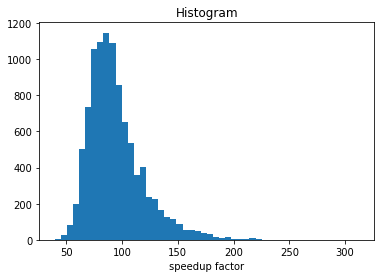

In [ ]:
speedups.rename('speedup factor').plot.hist(bins=50);

### Pareto frontier plots

In [ ]:
#@title Prepare dataframe
df = (
    df_raw
    .drop(['model', 'resolution', 'msec_per_sim_step'], axis=1)
    .set_index('model_name')
    .join(
        times.rename({'model': 'model_name'}).to_dataframe()
    )
    .join(
        times_boot
        .quantile(q=0.975, dim='boot')
        .drop('quantile')
        .rename('time_until_upper')
        .rename({'model': 'model_name'})
        .to_dataframe()
    )
    .join(
        times_boot
        .quantile(q=0.025, dim='boot')
        .drop('quantile')
        .rename('time_until_lower')
        .rename({'model': 'model_name'})
        .to_dataframe()
    )
    .reset_index()
)
df[['model', 'resolution']] = df.model_name.str.rsplit('_', 1, expand=True)
df['resolution'] = df['resolution'].astype(int)
# switch units from "msec per time step at 64x64" to
# "sec per simulation time step"
df['sec_per_sim_time'] = df['msec_per_dt'] / 0.007012 * 1e-3
df = df.sort_values(['resolution', 'model'])

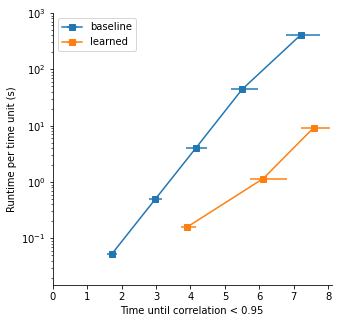

In [ ]:
#@title Pareto frontier with uncertainty

plt.figure(figsize=(5, 5))

df_baseline = df.query('model=="baseline"')
plt.errorbar(df_baseline.time_until,
             df_baseline.sec_per_sim_time,
             xerr=(df_baseline.time_until - df_baseline.time_until_lower,
                   df_baseline.time_until_upper - df_baseline.time_until),
             marker='s',
             label='baseline')

df_baseline = df.query('model=="learned_interp"')
plt.errorbar(df_baseline.time_until,
             df_baseline.sec_per_sim_time,
             xerr=(df_baseline.time_until - df_baseline.time_until_lower,
                   df_baseline.time_until_upper - df_baseline.time_until),
             marker='s',
             label='learned')

plt.xlim(0, 8.1)
plt.ylim(1.5e-2, 1e3)
plt.xlabel('Time until correlation < 0.95')
plt.ylabel('Runtime per time unit (s)')
plt.yscale('log')
plt.legend()
seaborn.despine()

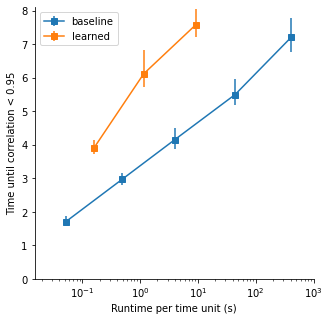

In [ ]:
#@title Pareto frontier (transposed) with uncertainty
plt.figure(figsize=(5, 5))

df_baseline = df.query('model=="baseline"')
plt.errorbar(df_baseline.sec_per_sim_time,
             df_baseline.time_until,
             yerr=(df_baseline.time_until - df_baseline.time_until_lower,
                   df_baseline.time_until_upper - df_baseline.time_until),
             marker='s',
             label='baseline')

df_baseline = df.query('model=="learned_interp"')
plt.errorbar(df_baseline.sec_per_sim_time,
             df_baseline.time_until,
             yerr=(df_baseline.time_until - df_baseline.time_until_lower,
                   df_baseline.time_until_upper - df_baseline.time_until),
             marker='s',
             label='learned')

plt.ylim(0, 8.1)
plt.xlim(1.5e-2, 1e3)
plt.ylabel('Time until correlation < 0.95')
plt.xlabel('Runtime per time unit (s)')
plt.xscale('log')
plt.legend()
seaborn.despine()

## Figure 2

Here we reproduce the key parts of Figure 2, from scratch.

Note that Figure 2 (and Figure 5) inadvertently used a different evaluation dataset than Figure 1 (different random initial velocity fields), saved at 64x64 resolution.

### Copy data

In [ ]:
%time ! gsutil -m cp gs://gresearch/jax-cfd/public_eval_datasets/kolmogorov_re_1000/learned*.nc /content

Copying gs://gresearch/jax-cfd/public_eval_datasets/kolmogorov_re_1000/learned_interpolation_long_eval_64x64_64x64.nc...
\ [1/1 files][  1.7 GiB/  1.7 GiB] 100% Done  56.8 MiB/s ETA 00:00:00           
Operation completed over 1 objects/1.7 GiB.                                      
CPU times: user 426 ms, sys: 72.6 ms, total: 499 ms
Wall time: 41.7 s


In [ ]:
%time ! gsutil -m cp gs://gresearch/jax-cfd/public_eval_datasets/kolmogorov_re_1000/long_eval*.nc /content

Copying gs://gresearch/jax-cfd/public_eval_datasets/kolmogorov_re_1000/long_eval_64x64_64x64.nc...
Copying gs://gresearch/jax-cfd/public_eval_datasets/kolmogorov_re_1000/long_eval_1024x1024_64x64.nc...
Copying gs://gresearch/jax-cfd/public_eval_datasets/kolmogorov_re_1000/long_eval_256x256_64x64.nc...
Copying gs://gresearch/jax-cfd/public_eval_datasets/kolmogorov_re_1000/long_eval_2048x2048_64x64.nc...
Copying gs://gresearch/jax-cfd/public_eval_datasets/kolmogorov_re_1000/long_eval_128x128_64x64.nc...
Copying gs://gresearch/jax-cfd/public_eval_datasets/kolmogorov_re_1000/long_eval_512x512_64x64.nc...
| [6/6 files][ 10.2 GiB/ 10.2 GiB] 100% Done  54.1 MiB/s ETA 00:00:00           
Operation completed over 6 objects/10.2 GiB.                                     
CPU times: user 1.88 s, sys: 347 ms, total: 2.22 s
Wall time: 3min 29s


### Load data at 64x64 and 32x32 resolutions

In [ ]:
import xarray
import seaborn
import jax_cfd.data.xarray_utils as xru
from jax_cfd.data import evaluation
import matplotlib.pyplot as plt

baseline_palette = seaborn.color_palette('YlGnBu', n_colors=7)[1:]
models_color = seaborn.xkcd_palette(['burnt orange'])
palette = baseline_palette + models_color


In [ ]:
filenames = {
    f'baseline_{r}': f'long_eval_{r}x{r}_64x64.nc'
    for r in [64, 128, 256, 512, 1024, 2048]
}
filenames['learned_interp_64'] = 'learned_interpolation_long_eval_64x64_64x64.nc'

models = {}
for k, v in filenames.items():
  models[k] = xarray.open_dataset(f'/content/{v}', chunks={'time': '100MB'})

combined = xarray.concat(list(models.values()), dim='model')
combined.coords['model'] = list(models.keys())
combined['vorticity'] = xru.vorticity_2d(combined)

In [ ]:
from jax_cfd.base import resize
import numpy as np
import pandas as pd

def resize_64_to_32(ds):
  coarse = xarray.Dataset({
      'u': ds.u.isel(x=slice(1, None, 2)).coarsen(y=2, coord_func='max').mean(),
      'v': ds.v.isel(y=slice(1, None, 2)).coarsen(x=2, coord_func='max').mean(),
  })
  coarse.attrs = ds.attrs
  return coarse

combined_32 = resize_64_to_32(combined)
combined_32['vorticity'] = xru.vorticity_2d(combined_32)

models_32 = {k: resize_64_to_32(v) for k, v in models.items()}

### Plot solutions: Fig 2(a)

In [ ]:
combined_32

<xarray.Dataset>
Dimensions:    (time: 3477, x: 32, y: 32, sample: 16, model: 7)
Coordinates:
  * time       (time) float64 0.0 0.07012 0.1402 0.2104 ... 243.6 243.7 243.8
  * x          (x) float64 0.1473 0.3436 0.54 0.7363 ... 5.645 5.841 6.038 6.234
  * y          (y) float64 0.1473 0.3436 0.54 0.7363 ... 5.645 5.841 6.038 6.234
  * sample     (sample) int32 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15
  * model      (model) <U17 'baseline_64' 'baseline_128' ... 'learned_interp_64'
Data variables:
    u          (model, sample, time, x, y) float32 dask.array<chunksize=(1, 16, 381, 32, 32), meta=np.ndarray>
    v          (model, sample, time, x, y) float32 dask.array<chunksize=(1, 16, 381, 32, 32), meta=np.ndarray>
    vorticity  (model, sample, time, x, y) float64 dask.array<chunksize=(1, 16, 381, 32, 32), meta=np.ndarray>
Attributes: (12/17)
    domain_size:                   [0.         6.28318531]
    domain_size_multiple:          1
    full_config_str:               \n# Macros:\n# ===========================...
    init_cfl_safety_factor:        0.5
    init_peak_wavenumber:          4.0
    maximum_velocity:              7.0
    ...                            ...
    simulation_time:               240.0
    stable_time_step:              0.007012483601762931
    time_subsample_factor:         1
    tracing_max_duration_in_msec:  100.0
    warmup_grid_size:              2048
    warmup_time:                   40.0

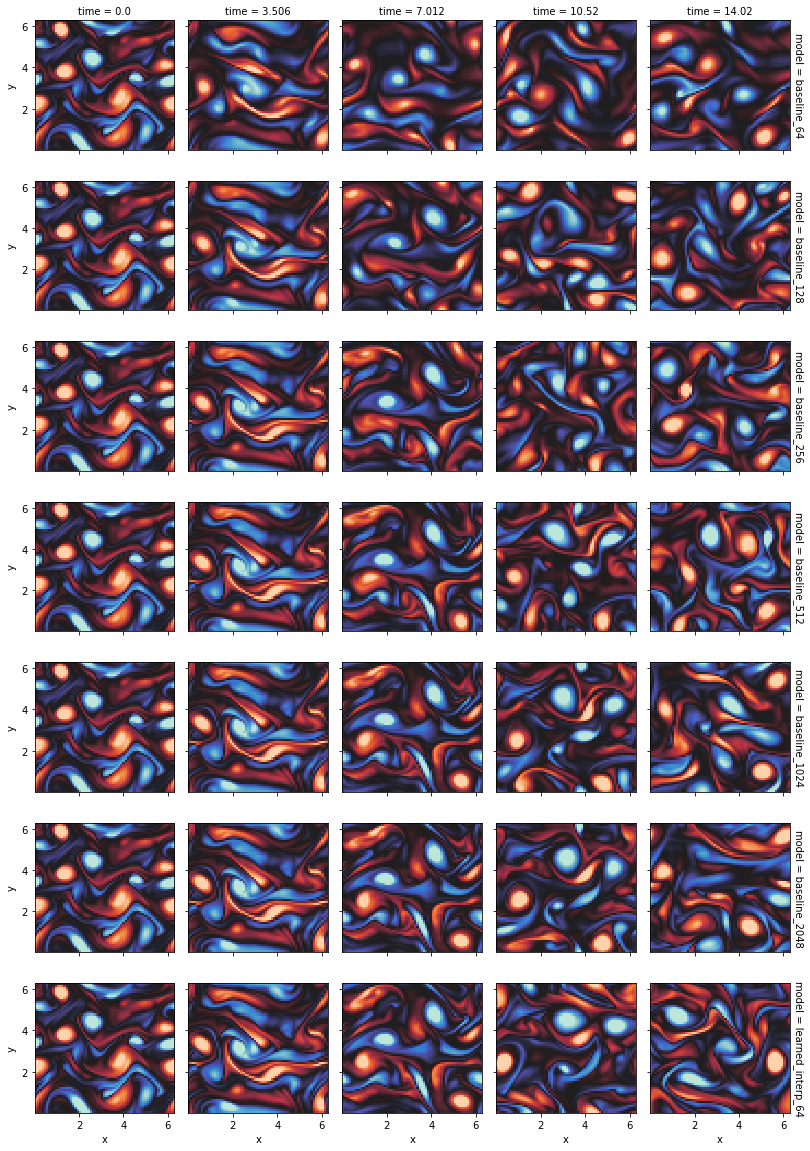

In [ ]:
combined.vorticity.isel(sample=0).thin(time=50).head(time=5).plot.imshow(
    row='model', col='time', x='x', y='y', robust=True, size=2.3, aspect=0.9,
    add_colorbar=False, cmap=seaborn.cm.icefire, vmin=-10, vmax=10)

### Calculate speed-up

We can calculate speed-up based upon vorticity correlation either at a resolution of 32x32 or 64x64. The numbers are similar.

Note that our ML models are slightly more effective than the FVM method on these dataset (138x vs 86x speedup), but still within the range of uncertainty.

In [ ]:
%%time
v = combined_32.vorticity.sel(time=slice(20))
vorticity_correlation = correlation(v, v.sel(model='baseline_2048')).compute()

times = calculate_time_until(vorticity_correlation)
times_boot = calculate_time_until_bootstrap(vorticity_correlation)

speedup = calculate_speedup(times)
print('speedup estimate:', float(speedup))

speedups = calculate_speedup(times_boot)
print('speedup bootstrap mean:', float(speedups.mean('boot')))
print('speedup bootstrap stddev:', float(speedups.std('boot')))
print('speedup bootstrap median:', float(speedups.median('boot')))
print('speedup bootstrap range:', speedups.quantile(dim='boot', q=[0.05, 0.95]).values.tolist())

upscaling = calculate_upscaling(times)
print('upscaling estimate:', float(upscaling))

upscalings = calculate_upscaling(times_boot)
print('upscaling bootstrap mean:', float(upscalings.mean('boot')))
print('upscaling bootstrap stddev:', float(upscalings.std('boot')))
print('upscaling bootstrap median:', float(upscalings.median('boot')))
print('upscaling bootstrap range:', upscalings.quantile(dim='boot', q=[0.05, 0.95]).values.tolist())


speedup estimate: 138.65628228906488
speedup bootstrap mean: 150.1622373446224
speedup bootstrap stddev: 56.7156225199758
speedup bootstrap median: 140.65924736688626
speedup bootstrap range: [78.28523529762678, 256.4975332101573]
upscaling estimate: 11.933315923931211
upscaling bootstrap mean: 12.065674792877463
upscaling bootstrap stddev: 1.3347147891240128
upscaling bootstrap median: 11.986456615013452
upscaling bootstrap range: [9.996538166582015, 14.438528892811396]
CPU times: user 12.3 s, sys: 1.97 s, total: 14.3 s
Wall time: 10.1 s


In [ ]:
%%time
v = combined.vorticity.sel(time=slice(20))
vorticity_correlation = correlation(v, v.sel(model='baseline_2048')).compute()

times = calculate_time_until(vorticity_correlation)
times_boot = calculate_time_until_bootstrap(vorticity_correlation)

speedup = calculate_speedup(times)
print('speedup estimate:', float(speedup))

speedups = calculate_speedup(times_boot)
print('speedup bootstrap mean:', float(speedups.mean('boot')))
print('speedup bootstrap stddev:', float(speedups.std('boot')))
print('speedup bootstrap median:', float(speedups.median('boot')))
print('speedup bootstrap range:', speedups.quantile(dim='boot', q=[0.05, 0.95]).values.tolist())

upscaling = calculate_upscaling(times)
print('upscaling estimate:', float(upscaling))

upscalings = calculate_upscaling(times_boot)
print('upscaling bootstrap mean:', float(upscalings.mean('boot')))
print('upscaling bootstrap stddev:', float(upscalings.std('boot')))
print('upscaling bootstrap median:', float(upscalings.median('boot')))
print('upscaling bootstrap range:', upscalings.quantile(dim='boot', q=[0.05, 0.95]).values.tolist())


speedup estimate: 146.00341279323766
speedup bootstrap mean: 159.08210350631379
speedup bootstrap stddev: 51.99629206702304
speedup bootstrap median: 151.11653189502027
speedup bootstrap range: [91.53284716965098, 256.4975332101573]
upscaling estimate: 12.125732532083184
upscaling bootstrap mean: 12.321154928480457
upscaling bootstrap stddev: 1.2015687231188004
upscaling bootstrap median: 12.255730858687793
upscaling bootstrap range: [10.492629382668657, 14.438528892811396]
CPU times: user 11.1 s, sys: 1.53 s, total: 12.6 s
Wall time: 8.6 s


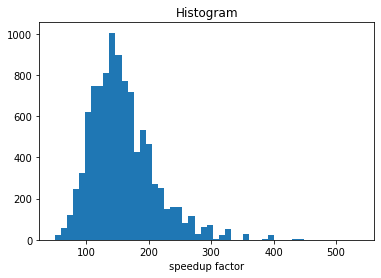

In [ ]:
speedups.rename('speedup factor').plot.hist(bins=50);

### Calculate metrics

In [ ]:
%%time
summary = xarray.concat([
    evaluation.compute_summary_dataset(ds, models['baseline_2048'])
    for ds in models.values()
], dim='model')
summary.coords['model'] = list(models.keys())

/usr/local/lib/python3.7/dist-packages/jax_cfd/data/xarray_utils.py:175: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  dask='parallelized')
/usr/local/lib/python3.7/dist-packages/jax_cfd/data/xarray_utils.py:175: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  dask='parallelized')
/usr/local/lib/python3.7/dist-packages/jax_cfd/data/xarray_utils.py:175: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  dask='parallelized')
/usr/local/lib/python3.7/dist-packages/jax_cfd/data/xarray_utils.py:175: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  dask='parallelized')
/usr/local/lib/pytho

CPU times: user 1min 19s, sys: 5.15 s, total: 1min 24s
Wall time: 52.7 s


In [ ]:
summary

<xarray.Dataset>
Dimensions:                       (time: 3477, model: 7, k: 30)
Coordinates:
  * time                          (time) float64 0.0 0.07012 ... 243.7 243.8
  * model                         (model) <U17 'baseline_64' ... 'learned_int...
  * k                             (k) float64 1.0 2.0 3.0 4.0 ... 28.0 29.0 30.0
Data variables: (12/31)
    u_mean                        (model, time) float32 dask.array<chunksize=(1, 381), meta=np.ndarray>
    v_mean                        (model, time) float32 dask.array<chunksize=(1, 381), meta=np.ndarray>
    kinetic_energy_mean           (model, time) float32 dask.array<chunksize=(1, 381), meta=np.ndarray>
    speed_mean                    (model, time) float32 dask.array<chunksize=(1, 381), meta=np.ndarray>
    energy_spectrum_mean          (model, k, time) float64 dask.array<chunksize=(1, 30, 381), meta=np.ndarray>
    enstrophy_mean                (model, time) float64 dask.array<chunksize=(1, 381), meta=np.ndarray>
    ...                            ...
    energy_spectrum_within_q=1.0  (model, k, time) bool dask.array<chunksize=(1, 30, 381), meta=np.ndarray>
    enstrophy_within_q=1.0        (model, time) float64 dask.array<chunksize=(1, 381), meta=np.ndarray>
    vorticity_within_q=1.0        (model, time) float64 dask.array<chunksize=(1, 381), meta=np.ndarray>
    u_correlation                 (model, time) float32 dask.array<chunksize=(1, 381), meta=np.ndarray>
    v_correlation                 (model, time) float32 dask.array<chunksize=(1, 381), meta=np.ndarray>
    vorticity_correlation         (model, time) float64 dask.array<chunksize=(1, 381), meta=np.ndarray>

In [ ]:
%time correlation = summary.vorticity_correlation.sel(time=slice(20)).compute()

CPU times: user 14.5 s, sys: 2.15 s, total: 16.6 s
Wall time: 9.33 s


In [ ]:
%time spectrum = summary.energy_spectrum_mean.tail(time=2000).mean('time').compute()

CPU times: user 2min 45s, sys: 13.6 s, total: 2min 58s
Wall time: 3min


### Plot correlation over time: Fig 2(b)

(0.0, 15.0)

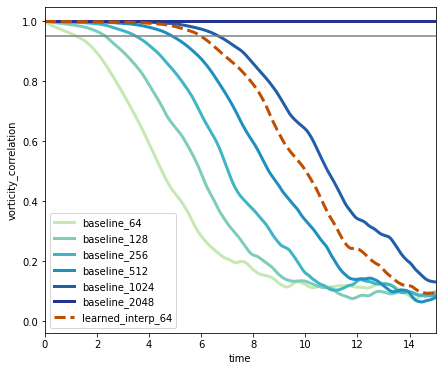

In [ ]:
plt.figure(figsize=(7, 6))
for color, model in zip(palette, summary['model'].data):
  style = '-' if 'baseline' in model else '--'
  correlation.sel(model=model).plot.line(
      color=color, linestyle=style, label=model, linewidth=3);
plt.axhline(y=0.95, xmin=0, xmax=20, color='gray')
plt.legend();
plt.title('')
plt.xlim(0, 15)

### Plot spectrum: Fig 2(c)

(1000000000.0, 5696212345.813846)

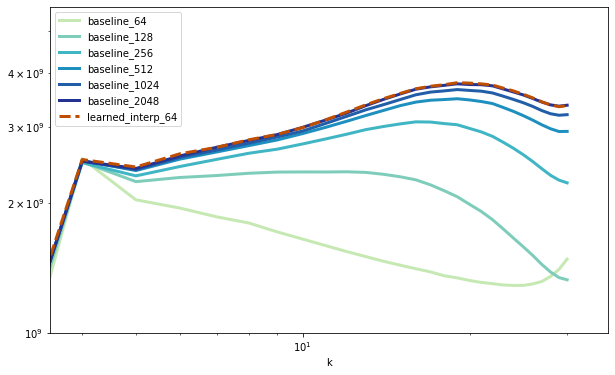

In [ ]:
plt.figure(figsize=(10, 6))
for color, model in zip(palette, summary['model'].data):
  style = '-' if 'baseline' in model else '--'
  (spectrum.k ** 5 * spectrum).sel(model=model).plot.line(
      color=color, linestyle=style, label=model, linewidth=3);
plt.legend();
plt.yscale('log')
plt.xscale('log')
plt.title('')
plt.xlim(3.5, None)
plt.ylim(1e9, None)